# We have four scenarios:
- High truck cost, weekly scheduling
- High truck cost, daily scheduling (with a 50% daily premium paid for the luxury)
- Low truck cost, weekly scheduling
- Low truck cost, daily scheduling (with a 50% daily premium paid for the luxury)

Weekly truck rental data from [here](https://www.budgettrucks.com.au/en/offers/vic/weekly-rates).

We get the following objective solutions for each scenario:
- WTLC:
```
{'NumTrucks': 50.0,
 'TruckHire': 35000.0,
 'TransportCosts': 115001.0,
 'ShortageCosts': 0.0,
 'HoldingCosts': 50000.0,
 'TotalCost': 200001.0}
 ```
 - WTHC:
```
{'NumTrucks': 50.0,
 'TruckHire': 70000.0,
 'TransportCosts': 114981.0,
 'ShortageCosts': 0.0,
 'HoldingCosts': 50000.0,
 'TotalCost': 234981.0}
```
- DTLC
```
{'NumTrucks': 50.0,
 'TruckHire': 52500.0,
 'TransportCosts': 114981.0,
 'ShortageCosts': 0.0,
 'HoldingCosts': 50000.0,
 'TotalCost': 217481.0}
```
- DTHC
```
{'NumTrucks': 38.0,
 'TruckHire': 79800.0,
 'TransportCosts': 115024.0,
 'ShortageCosts': 0.0,
 'HoldingCosts': 74000.0,
 'TotalCost': 268824.0}
```

# Conclusions:
- Daily truck hire is a substantial cost saving when dealing with high truck rental costs, as is expected over high-demand periods like Black Friday.
- Lower truck hire can be feasible in periods with high truck hire prices, but cost savings will be partially offset by increased holding costs as trucks need to store more at retailers in preparation for Black Friday.

In [316]:
# data import and cleaning
import numpy as np
import json

# "../data/weekly_trucks_low_cost.json"
# "../data/weekly_trucks_high_cost.json"
# "../data/daily_trucks_low_cost.json"
# "../data/daily_trucks_high_cost.json"

with open("../data/daily_trucks_high_cost.json", 'r') as f:
    input_data = json.load(f)

num_warehouses = input_data['num_warehouses']
num_goods = input_data['num_goods']
num_retailers = input_data['num_retailers']
num_periods = input_data['num_periods']
truck_capacity = input_data['truck_capacity']
truck_daily_rental_cost = input_data['truck_daily_rental_cost']
truck_rental_period = input_data['truck_rental_period']
shortage_costs = input_data['shortage_costs']
holding_costs = input_data['holding_costs']
good_sizes = input_data['good_sizes']
demand_raw = input_data['demand']
transport_costs_raw = input_data['transportation_costs']


retailer_good_demand = np.ndarray(shape=(num_retailers, num_goods, num_periods))
for retailer, goods_demanded in demand_raw.items():
    for good, demand_schedule  in goods_demanded.items():
        for period, demand in enumerate(demand_schedule):
            retailer_good_demand[int(retailer), int(good), int(period)] = demand

transportation_costs = np.zeros(shape=(num_retailers, num_warehouses, num_goods))
for warehouse, retailer_good_costs  in transport_costs_raw.items():
    for retailer, good_costs in retailer_good_costs.items():
        for good, transport_cost in enumerate(good_costs):
            transportation_costs[int(warehouse), int(retailer), int(good)] = transport_cost

print(f"""Data loaded successfully!
    - num_warehouses: {num_warehouses}
    - num_goods: {num_goods}
    - num_retailers {num_retailers}
    - num_periods: {num_periods}
    - truck_capacity: {truck_capacity}
    - truck_daily_rental_cost: {truck_daily_rental_cost}
    - truck_rental_period: {truck_rental_period}
    - shortage_costs: {shortage_costs}
    - holding_costs: {holding_costs}
    - good_sizes: {good_sizes}
    - retailer_good_demand:\n {retailer_good_demand}
    - transportation_costs:\n {transportation_costs}
""")

Data loaded successfully!
    - num_warehouses: 5
    - num_goods: 3
    - num_retailers 5
    - num_periods: 7
    - truck_capacity: 1000
    - truck_daily_rental_cost: 300
    - truck_rental_period: daily
    - shortage_costs: [20, 50, 200]
    - holding_costs: [2, 5, 20]
    - good_sizes: [1, 2, 1]
    - retailer_good_demand:
 [[[ 1000.   500.   300.   100. 10000.  6000.  4000.]
  [  500.   200.     0.     0.  2000.   100.   200.]
  [  100.    50.    30.    10.  1000.   800.   800.]]

 [[ 1000.   500.   300.   100. 10000.  6000.  4000.]
  [  500.   200.     0.     0.  2000.   100.   200.]
  [  100.    50.    30.    10.  1000.   800.   800.]]

 [[ 1000.   500.   300.   100. 10000.  6000.  4000.]
  [  500.   200.     0.     0.  2000.   100.   200.]
  [  100.    50.    30.    10.  1000.   800.   800.]]

 [[ 1000.   500.   300.   100. 10000.  6000.  4000.]
  [  500.   200.     0.     0.  2000.   100.   200.]
  [  100.    50.    30.    10.  1000.   800.   800.]]

 [[ 1000.   500.   300. 

In [317]:
import gurobipy as gp

m = gp.Model()

warehouses = range(num_warehouses)
goods = range(num_goods)
retailers = range(num_retailers)
periods = range(num_periods)
truck_rental_period = "weekly"

if truck_rental_period == "weekly":
    num_trucks = m.addVar(lb=0, ub=num_warehouses * 10, vtype='I', name="NumTrucks")
elif truck_rental_period == "daily":
    num_trucks = m.addMVar(num_periods, lb=0, ub=num_warehouses * 10, vtype='I', name="NumTrucks")
else:
    raise NotImplementedError("Only supports `weekly` or `daily` truck rental.")

truck_allocation = m.addMVar((num_warehouses, num_periods), lb=0, ub=1000, vtype='I', name="TruckAllocation")
transport = m.addMVar((num_warehouses, num_retailers, num_goods, num_periods), lb=0, ub=10000, vtype='I', name="TransportedGoods")
carried_retailer_stock = m.addMVar((num_retailers, num_goods, num_periods+1), lb=0, ub=10000, vtype='I', name="RetailerHeldStock")
short_retailer_stock = m.addMVar((num_retailers, num_goods, num_periods), lb=0, ub=10000, vtype='I', name="RetailerShortStock")

if truck_rental_period == "weekly":
    m.setObjective(
        gp.quicksum(transport[w, r, g, p] * transportation_costs[w, r, g] for w in warehouses for r in retailers for g in goods for p in periods) +
        gp.quicksum(short_retailer_stock[r, g, p] * shortage_costs[g] for g in goods for r in retailers for p in periods) +
        gp.quicksum(carried_retailer_stock[r, g, p] * holding_costs[g] for g in goods for r in retailers for p in range(num_periods+1)) +
        num_trucks * truck_daily_rental_cost * num_periods,
        gp.GRB.MINIMIZE
    )
elif truck_rental_period == "daily":
        m.setObjective(
        gp.quicksum(transport[w, r, g, p] * transportation_costs[w, r, g] for w in warehouses for r in retailers for g in goods for p in periods) +
        gp.quicksum(short_retailer_stock[r, g, p] * shortage_costs[g] for g in goods for r in retailers for p in periods) +
        gp.quicksum(carried_retailer_stock[r, g, p] * holding_costs[g] for g in goods for r in retailers for p in range(num_periods+1)) +
        gp.quicksum(num_trucks[p] for p in periods) * truck_daily_rental_cost,
        gp.GRB.MINIMIZE
    )

if truck_rental_period == "weekly":
    # total number of trucks allocated across all warehouses for each period must equal number of trucks hired
    m.addConstrs((gp.quicksum(truck_allocation[w, p] for w in warehouses) == num_trucks for p in periods), name="TruckAllocation")
elif truck_rental_period == "daily":
    # total number of trucks allocated across all warehouses for each period must equal number of trucks hired
    m.addConstrs((gp.quicksum(truck_allocation[w, p] for w in warehouses) == num_trucks[p] for p in periods), name="TruckAllocation")

# total goods sent from a warehouse in each period cannot exceed the capacity of its assigned trucks
m.addConstrs((gp.quicksum(gp.quicksum(transport[w, r, g, p] for r in retailers) * good_sizes[g] for g in goods) <= truck_allocation[w, p] * truck_capacity for w in warehouses for p in periods), name="TruckCapacities")

# first period carried retailer stock equal to 0
m.addConstrs((carried_retailer_stock[r, g, 0] == 0 for r in retailers for g in goods), name="InitialRetailerStock")

# amount of retailer goods carried each period equal to the excess demand in each period
m.addConstrs(
    (
        carried_retailer_stock[r, g, p + 1] == gp.quicksum(transport[w, r, g, p] for w in warehouses) - retailer_good_demand[r, g, p] + carried_retailer_stock[r, g, p] for r in retailers for g in goods for p in periods
    ), name="RetailerCarryAmounts"
)

# amount of retailer goods short of demand is equal to the unmet demand in each period
m.addConstrs(
    (
        short_retailer_stock[r, g, p] >= retailer_good_demand[r, g, p] - carried_retailer_stock[r, g, p] - gp.quicksum(transport[w, r, g, p] for w in warehouses) for r in retailers for g in goods for p in periods
    ), name="RetailerShortAmounts"
)

m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 267 rows, 786 columns and 2087 nonzeros
Model fingerprint: 0x751c3684
Variable types: 0 continuous, 786 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e-01, 2e+03]
  Bounds range     [5e+01, 1e+04]
  RHS range        [1e+01, 1e+04]
Found heuristic solution: objective 619650.00000
Presolve removed 132 rows and 132 columns
Presolve time: 0.00s
Presolved: 135 rows, 654 columns, 1298 nonzeros
Variable types: 0 continuous, 654 integer (0 binary)

Root relaxation: objective 2.687585e+05, 182 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [318]:
m.objVal

268824.0

In [319]:
retail_stock = []

for retailer in retailers:
    for good in goods:
        for period in periods:
            retail_stock.append(
                {
                    "Retailer": f"Retail{retailer}",
                    "Good": f"Good{good}",
                    "Period": period,
                    "InitialStock": carried_retailer_stock[retailer][good][period].x.item() + 0.0,
                    "DailySupply": sum(transport[w, retailer, good, period].x + 0.0 for w in warehouses),
                    "Demand": retailer_good_demand[retailer][good][period],
                    "ShortStock": short_retailer_stock[retailer][good][period].x.item() + 0.0,
                }
            )

retail_stock

[{'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 0,
  'InitialStock': 0.0,
  'DailySupply': 1000.0,
  'Demand': 1000.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 1,
  'InitialStock': 0.0,
  'DailySupply': 500.0,
  'Demand': 500.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 2,
  'InitialStock': 0.0,
  'DailySupply': 300.0,
  'Demand': 300.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 3,
  'InitialStock': 0.0,
  'DailySupply': 7520.0,
  'Demand': 100.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 4,
  'InitialStock': 7420.0,
  'DailySupply': 2580.0,
  'Demand': 10000.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 5,
  'InitialStock': 0.0,
  'DailySupply': 6000.0,
  'Demand': 6000.0,
  'ShortStock': 0.0},
 {'Retailer': 'Retail0',
  'Good': 'Good0',
  'Period': 6,
  'InitialStock': 0.0,
  'DailySupply': 4000.0,


In [320]:
import pandas as pd

retail_stock_df = pd.DataFrame.from_records(retail_stock)

retail_stock_df = retail_stock_df.melt(id_vars=["Retailer", "Good", "Period"], value_vars=["InitialStock", "DailySupply", "Demand", "ShortStock"])

retail_stock_df

,Retailer,Good,Period,variable,value
0,Retail0,Good0,0,InitialStock,0.0
1,Retail0,Good0,1,InitialStock,0.0
2,Retail0,Good0,2,InitialStock,0.0
3,Retail0,Good0,3,InitialStock,0.0
4,Retail0,Good0,4,InitialStock,7420.0
...,...,...,...,...,...
415,Retail4,Good2,2,ShortStock,0.0
416,Retail4,Good2,3,ShortStock,0.0
417,Retail4,Good2,4,ShortStock,0.0
418,Retail4,Good2,5,ShortStock,0.0


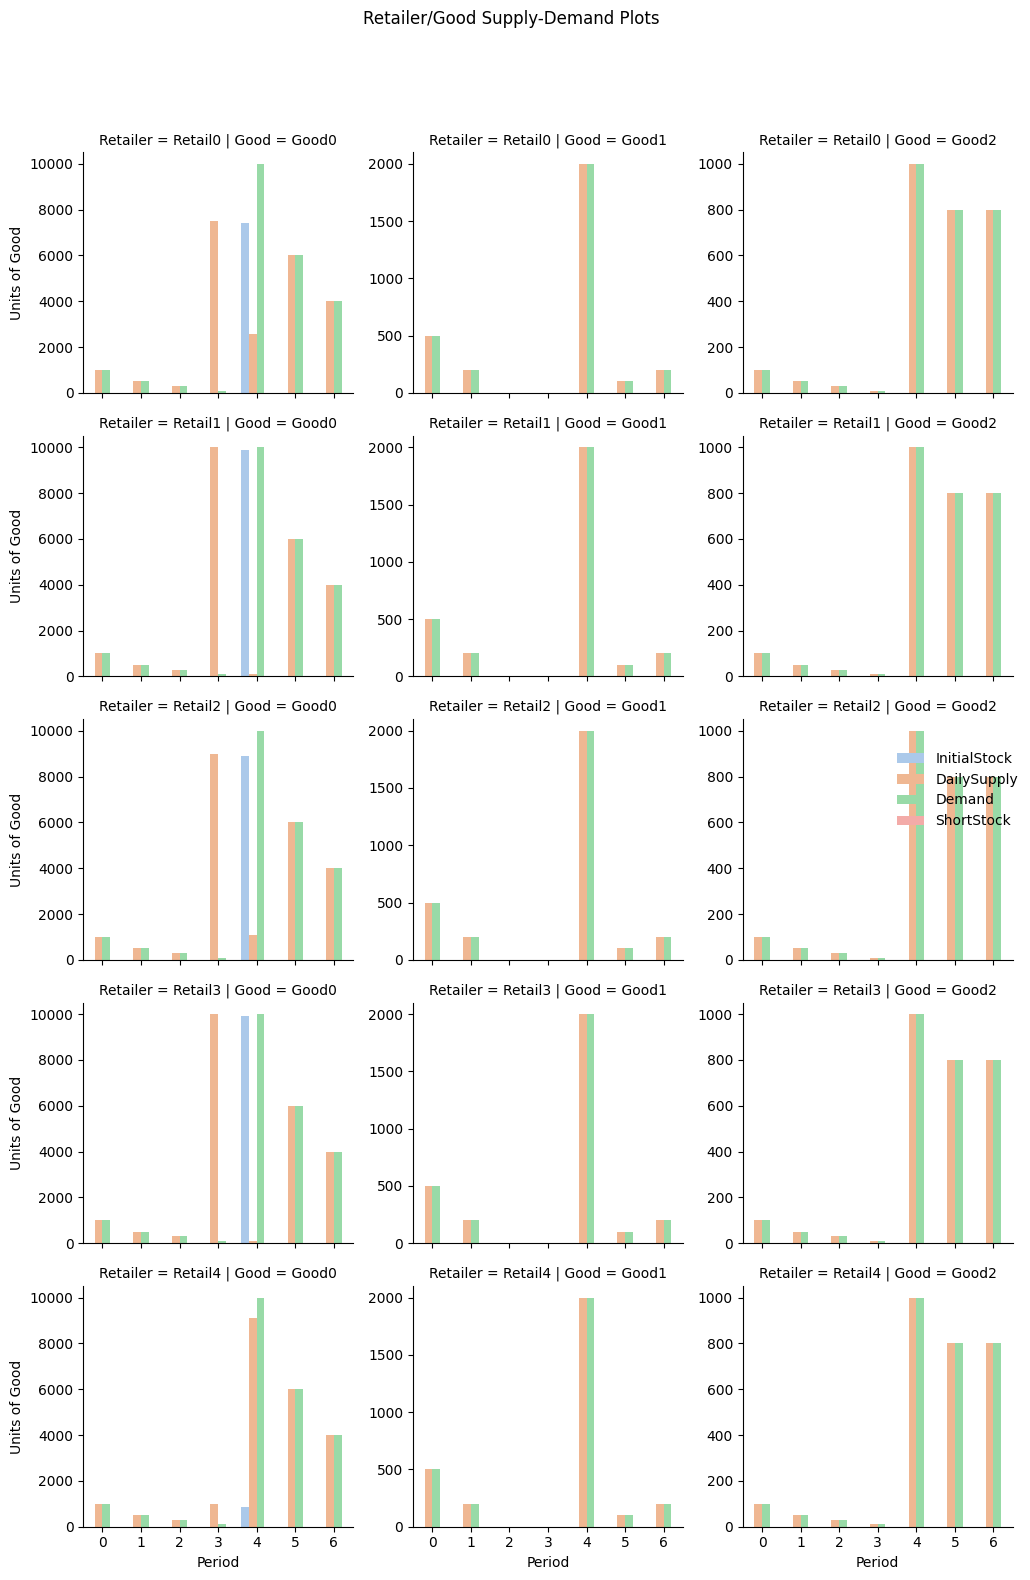

In [321]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(retail_stock_df, col="Good",  row="Retailer", sharey=False)
g.map_dataframe(sns.barplot, x="Period", y="value", hue="variable", dodge=True, palette="pastel")


# Add legend and adjust layout
g.add_legend()
g.set_axis_labels("Period", "Units of Good")
g.fig.suptitle("Retailer/Good Supply-Demand Plots", y=1.05)
plt.tight_layout()

# Show the plot
plt.show()

In [322]:
truck_utilisation = []

for warehouse in warehouses:
    for period in periods:
        truck_utilisation.append(
            {
                'Warehouse': f"Warehouse{warehouse}",
                'Period': period,
                'AssignedTrucks': truck_allocation[warehouse, period].x + 0.0,
                'TotalCapacity': (truck_allocation[warehouse, period].x + 0.0) * truck_capacity,
                'TotalSupplied': sum(transport[warehouse, r, g, period].x + 0.0 for r in retailers for g in goods)
            }
        )

truck_utilisation

[{'Warehouse': 'Warehouse0',
  'Period': 0,
  'AssignedTrucks': 13.0,
  'TotalCapacity': 13000.0,
  'TotalSupplied': 3300.0},
 {'Warehouse': 'Warehouse0',
  'Period': 1,
  'AssignedTrucks': 19.0,
  'TotalCapacity': 19000.0,
  'TotalSupplied': 1550.0},
 {'Warehouse': 'Warehouse0',
  'Period': 2,
  'AssignedTrucks': 24.0,
  'TotalCapacity': 24000.0,
  'TotalSupplied': 690.0},
 {'Warehouse': 'Warehouse0',
  'Period': 3,
  'AssignedTrucks': 18.0,
  'TotalCapacity': 18000.0,
  'TotalSupplied': 17550.0},
 {'Warehouse': 'Warehouse0',
  'Period': 4,
  'AssignedTrucks': 14.0,
  'TotalCapacity': 14000.0,
  'TotalSupplied': 9840.0},
 {'Warehouse': 'Warehouse0',
  'Period': 5,
  'AssignedTrucks': 15.0,
  'TotalCapacity': 15000.0,
  'TotalSupplied': 14600.0},
 {'Warehouse': 'Warehouse0',
  'Period': 6,
  'AssignedTrucks': 13.0,
  'TotalCapacity': 13000.0,
  'TotalSupplied': 10800.0},
 {'Warehouse': 'Warehouse1',
  'Period': 0,
  'AssignedTrucks': 5.0,
  'TotalCapacity': 5000.0,
  'TotalSupplied': 1

In [323]:
truck_utilisation_df = pd.DataFrame.from_records(truck_utilisation)

truck_utilisation_df['Utilisation'] = (truck_utilisation_df['TotalSupplied'] / truck_utilisation_df['TotalCapacity']).fillna(1.0).apply(lambda x: "{:.2f}".format(x))

truck_utilisation_df

,Warehouse,Period,AssignedTrucks,TotalCapacity,TotalSupplied,Utilisation
0,Warehouse0,0,13.0,13000.0,3300.0,0.25
1,Warehouse0,1,19.0,19000.0,1550.0,0.08
2,Warehouse0,2,24.0,24000.0,690.0,0.03
3,Warehouse0,3,18.0,18000.0,17550.0,0.97
4,Warehouse0,4,14.0,14000.0,9840.0,0.70
5,Warehouse0,5,15.0,15000.0,14600.0,0.97
6,Warehouse0,6,13.0,13000.0,10800.0,0.83
7,Warehouse1,0,5.0,5000.0,100.0,0.02
8,Warehouse1,1,5.0,5000.0,50.0,0.01
9,Warehouse1,2,3.0,3000.0,30.0,0.01


In [324]:
total_utilisation = sum(truck_utilisation_df['TotalSupplied']) / sum(truck_utilisation_df['TotalCapacity'])

total_utilisation

0.5204887218045112

In [325]:
if truck_rental_period == "weekly":
    cost_attribution = {
        'NumTrucks': num_trucks.x,
        'TruckHire': num_trucks.x * truck_daily_rental_cost * num_periods,
        'TransportCosts': sum(transport[w, r, g, p].x * transportation_costs[w, r, g] for w in warehouses for r in retailers for g in goods for p in periods),
        'ShortageCosts': sum(short_retailer_stock[r, g, p].x * shortage_costs[g] for g in goods for r in retailers for p in periods),
        'HoldingCosts': sum(carried_retailer_stock[r, g, p].x * holding_costs[g] for g in goods for r in retailers for p in range(num_periods+1)),
        'TotalCost': m.objVal
    }
elif truck_rental_period == "daily":
    cost_attribution = {
        'NumTrucks': num_trucks.x + 0.0,
        'TruckHire': sum(num_trucks.x) * truck_daily_rental_cost,
        'TransportCosts': sum(transport[w, r, g, p].x * transportation_costs[w, r, g] for w in warehouses for r in retailers for g in goods for p in periods),
        'ShortageCosts': sum(short_retailer_stock[r, g, p].x * shortage_costs[g] for g in goods for r in retailers for p in periods),
        'HoldingCosts': sum(carried_retailer_stock[r, g, p].x * holding_costs[g] for g in goods for r in retailers for p in range(num_periods+1)),
        'TotalCost': m.objVal
    }
else:
    cost_attribution = {}

cost_attribution

{'NumTrucks': 38.0,
 'TruckHire': 79800.0,
 'TransportCosts': 115024.0,
 'ShortageCosts': 0.0,
 'HoldingCosts': 74000.0,
 'TotalCost': 268824.0}